In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
from __future__ import print_function
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
from functools import partial

# **Google OR Tools**
> Open Source Software for *Combinatorial Optimization*


## Problem Requirement:
<hr style="height:1px">

**1. First Mile Problem (Pickup Run Sheet)**
<br><u>Given:</u> Number of Locations, Pickup Demands, Available Fleet Sizes
<br><u>Output:</u> Optimal Route, No. of Vehicles to be used, and Fleet Size/Type to be used

**2. Last Mile Problem (Delivery Run Sheet)**
<br><u>Given:</u>	Number of Locations, Delivery Demands, Available Fleet Sizes
<br><u>Output:</u> Optimal Route, No. of Vehicles to be used, and Fleet Size/Type to be used
<hr style="height:1px">

### Content
1. CVRP Problem
2. Changing the search strategy (Guided Local Search)
3. Changing the Objective Function (Distance*Capacity)
4. Changing the available Fleet Size (Limited vs Limitless instances of each vehicle type)
5. A "fair" distribution of loads
6. Make every vehicle do something
7. Other Possible Constraints**

**Let's explore and analyze a basic pickup problem first - Capacited Vehicles Routing Problem (CVRP)**

## Capacitated Vehicle Routing Problem (CVRP)
* VRP with capacity constraints, in which vehicles with limited carrying capacity need to <b>pick up</b> or <b>deliver</b> items at various locations.
* The items have a quantity, such as weight or volume, and the vehicles have a maximum capacity that they can carry. 
* The problem is to pick up the items for the least cost, while never exceeding the capacity of the vehicles.

> Note: In the following example, we assume that all items are being picked up. The program that solves this problem also works if all items are being delivered (Delivery can be thought as negative pickup).

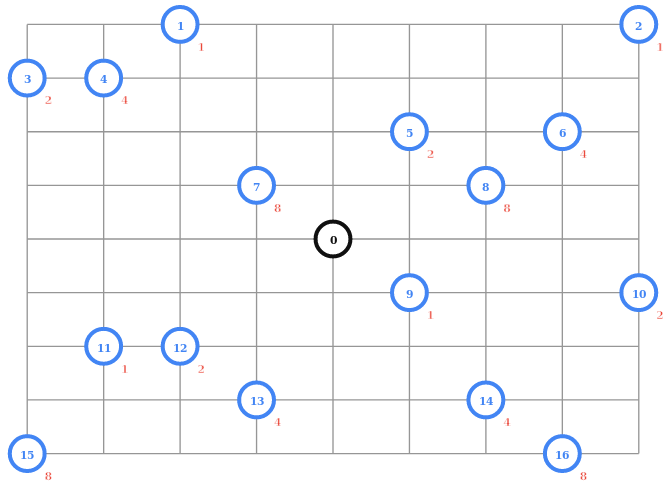

### Procedure To Solve CVRP (VRP with Capacity Constraints)

1.  Input the variables 
* Create the routing model
* Create The Distance Callback
* Set The Cost of Travel
* Create the Demand Callback
* Add a Capacity Dimension
* Set search parameters and Solve
* Output the Objective & Route

### 1. Input The Variables

1. **Distance Matrix:** An array whose i, j entry is the distance from location i to location j in km
* **Demands:** Each location has a demand corresponding to the quantity—for example, weight or volume—of the item to be picked up.
* **Capacities:** Each vehicle has a capacity - the maximum quantity that the vehicle can hold. 
* **Num_vehicle:** The number of available vehicles
* **Depot:** The start and end location for the route. In this case, the depot is 0.

In [9]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [
        [   0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662       ],
        [   548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210    ],
        [   776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754   ],
        [   696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358    ],
        [   582, 194, 878, 114, 0, 536 , 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244   ],
        [   274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708      ],
        [   502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480     ],
        [   194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856       ],
        [   308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514      ],
        [   194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468       ],
        [   536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354   ],
        [   502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844     ],
        [   388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730      ],
        [   354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536      ],
        [   468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194    ],
        [   776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798  ],
        [   662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0    ],
    ]
    data['demands'] = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]
    data['vehicle_capacities'] = [15, 15, 15, 15]
    data['num_vehicles'] = 4
    data['depot'] = 0
    return data
# Instantiate the data problem.
data = create_data_model()

display(pd.DataFrame(data['distance_matrix']))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,548,776,696,582,274,502,194,308,194,536,502,388,354,468,776,662
1,548,0,684,308,194,502,730,354,696,742,1084,594,480,674,1016,868,1210
2,776,684,0,992,878,502,274,810,468,742,400,1278,1164,1130,788,1552,754
3,696,308,992,0,114,650,878,502,844,890,1232,514,628,822,1164,560,1358
4,582,194,878,114,0,536,764,388,730,776,1118,400,514,708,1050,674,1244
5,274,502,502,650,536,0,228,308,194,240,582,776,662,628,514,1050,708
6,502,730,274,878,764,228,0,536,194,468,354,1004,890,856,514,1278,480
7,194,354,810,502,388,308,536,0,342,388,730,468,354,320,662,742,856
8,308,696,468,844,730,194,194,342,0,274,388,810,696,662,320,1084,514
9,194,742,742,890,776,240,468,388,274,0,342,536,422,388,274,810,468


### 2. Create the routing model
The inputs to RoutingIndexManager are:

* The number of rows of the distance matrix, which is the number of locations (including the depot).
* The number of vehicles in the problem.
* The node corresponding to the depot.

In [10]:
# Create the routing index manager (Manager for any Distance Matrix NodeIndex <-> Routing variable index conversion)
# Parameters (num_locations, num_vehicles, starts_ends)
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

### 3. Create The Distance Callback
The distance callback—the function that returns the distance between any two locations.
> The callback accepts two indices, from_index and to_index, and returns the corresponding entry of the distance matrix. 

In [11]:
# Create and register a transit callback.
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

### 4.  Set The Cost of Travel
The arc cost evaluator tells the solver how to calculate the cost of travel between any two locations—in other words, the cost of the edge (or arc) joining them in the graph for the problem. The following code sets the arc cost evaluator. 

In [13]:
# Define cost of each arc.
# Parameters (evaluator_index)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

### 5. Create the Demand Callback
**Demand Callback** - It returns the demand at each location

In [17]:
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

#The following function registers demand_callback with the solver
demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)      

### 6. Add a Capacity Dimension
**Capacity Dimension** - It computes the weight of the load a vehicle is carrying- a quantity that accumulates over the route 

In [18]:
# Creates the capacity dimension

routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

True

### 7. Set search parameters and Solve
The following code sets the default search parameters and a heuristic method for finding the first solution: 
>The code sets the first solution strategy to PATH_CHEAPEST_ARC, which creates an initial route for the solver by repeatedly adding edges with the least weight that don't lead to a previously visited node (other than the depot). 

In [29]:
# 7(A) SET SEARCH PARAMETERS (Setting First Solution Heuristic)

search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
#search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
#search_parameters.time_limit.seconds = 30


# 7(B) SOLVE THE PROBLEM
solution = routing.SolveWithParameters(search_parameters)

### 8. Output the Objective & Route

The function that displays the solution returned by the solver is shown below. The function extracts the route from the solution and prints it to the console.
> The function displays the optimal route and its distance, which is given by ObjectiveValue().

In [30]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    #print('routing.Size():',routing.Size())
    total_distance = 0
    max_route_distance = 0
    ###
    total_load = 0
    
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        ###
        route_load = 0
        
        while not routing.IsEnd(index):
            
            ###
            # node_index and route_load in output
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            
            # next four are same as before
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index), route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        ###
        plan_output += 'Load of the route: {}\n'.format(route_load)
        total_load += route_load

        total_distance += route_distance        
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)              
    print('Maximum of the route distances: {}m'.format(max_route_distance))
    print('Total distance of all routes: {}m'.format(total_distance))
    ###
    print('Total load of all routes: {}'.format(total_load))

In [31]:
# PRINT SOLUTION ON THE CONSOLE
if solution:
    print_solution(data, manager, routing, solution)

Route for vehicle 0:
 0 Load(0) ->  1 Load(1) ->  4 Load(5) ->  3 Load(7) ->  15 Load(15) ->  0 Load(15)
Distance of the route: 2192m
Load of the route: 15

Route for vehicle 1:
 0 Load(0) ->  14 Load(4) ->  16 Load(12) ->  10 Load(14) ->  2 Load(15) ->  0 Load(15)
Distance of the route: 2192m
Load of the route: 15

Route for vehicle 2:
 0 Load(0) ->  7 Load(8) ->  13 Load(12) ->  12 Load(14) ->  11 Load(15) ->  0 Load(15)
Distance of the route: 1324m
Load of the route: 15

Route for vehicle 3:
 0 Load(0) ->  9 Load(1) ->  8 Load(9) ->  6 Load(13) ->  5 Load(15) ->  0 Load(15)
Distance of the route: 1164m
Load of the route: 15

Maximum of the route distances: 2192m
Total distance of all routes: 6872m
Total load of all routes: 60


## Changing the search strategy
The routing solver does not always return the optimal solution to a TSP, because routing problems are computationally intractable. For instance, the solution returned in the previous example is not the optimal route. 

<br>To find a better solution, you can use a more advanced search strategy, called **guided local search**, which enables the solver to escape a local minimum—a solution that is shorter than all nearby routes, but which is not the global minimum. After moving away from the local minimum, the solver continues the search.

>**Guided Local Search:** This is a metaheuristic search method. A meta-heuristic method is a method that sits on top of a local search algorithm to change its behavior.

>**How does it work ?** Guided Local Search builds up penalties during a search. It uses penalties to help local search algorithms escape from local minimal and plateaus. When the given local search algorithm settles in a local optimum, GLS modifies the objective function using a specific scheme. Then the local search will operate using an augmented objective function, which is designed to bring the search out of the local optimum. The key is in the way that the objective function is modified. 



In [33]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.seconds = 30
#search_parameters.log_search = True

The difference in observed with the above example by using Guided Local Search

**1. Using PATH_CHEAPEST_ARC**
<img src = "cvrp1.png">

**2. Using GUIDED_LOCAL_SEARCH**
<img src = "cvrp2.png">

## Changing the Objective Function
**Objective:** Cost Optimisation

> Q: What is Cost ?
><br> Cost Function for any arc = Distance (Length of arc) * Capacity (of the vehicle traveled)

We can consider Frieght cost or any other factor as well. 

>**Impact:**
<br>Suppose we have two potential vehicle available (car and truck) to use for a defined route. The solver by default selects the larger vehicle of the two. By using this metric as cost function, the solver chooses the smaller vehicle with low frieght cost for the route.
>> This saves the extra operating cost.

In [34]:
'''3. Create The Total Cost Callback    '''    
def vehicle_distance_callback(data, vehicle, manager, from_index, to_index):
    """Returns the distance between the two nodes for a vehicle."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]*data['vehicle_capacities'][vehicle]

# then later...
# use per-vehicle arc cost evaluators

vehicle_transits = [
    routing.RegisterTransitCallback(
        partial(vehicle_distance_callback, data, v, manager)
    ) for v in range(0,data['num_vehicles'])]

'''4. Set The Cost of Travel'''
vehicle_costs = [
    routing.SetArcCostEvaluatorOfVehicle(
        t,v
    ) for (t,v) in zip(vehicle_transits,
                        range(0,data['num_vehicles']))]

This isn’t a “distance” metric, so much as a **cost per km metric**. Since I want the solver to minimize the cost of the solution, this is okay. All else being equal, the high capacity vehicles are more expensive to use to travel between any two locations. 

### Example
For a pickup problem on a particular day for Bangalore City, the actual used vehicles and followed route were as follows:

>The available vehicle types were **TATA 407 > TATA TT > TATA ACE** in the order of their capaciy. 

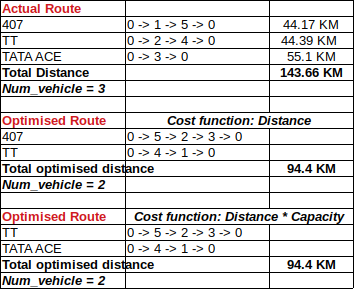

> Changing the cost function makes the solver to choose TT instead of 407 for the same route which will save the cost of using larger vehicle.

## Changing the available Fleet Size

Typically in a solver run, the solver is allowed to use any number of the vehicles, with no restrictions on the various combinations of vehicle types used.

Running the optimiser for *limited number of fleet* and *limitless number of fleet* showed different results in terms of optimising the total optimisation cost. The following example illustrates the result. 

### Example

For a pickup problem on a particular day for Mumbai City, the actual used vehicles and followed route were as follows:

<img src = "M1.jpeg">

The following results were obtained for two different cases of fleet size used:

<img src = "M2.jpeg">

**Total Distance Travelled**
<BR>*Case 1:* 125.5 Km 
<BR>*Case 2:* 159.4 Km
    
**Total Cost (Capacity*Distance) Value**
<br>*Case 1:* 25672800
<br>*Case 2:* 21489456

> **RESULT:** The first case, for sure, has the lower distance as compared to the second case, but the total operating cost for this solution set is high. Therefore, the second case gives us a better and optimal answer in terms of total operating cost. 

## A "fair" distribution of loads

> The question is how to balance work across a fleet of vehicles.

Suppose you have a fleet of 5 vehicles and 50 pickups, but each vehicle has a capacity of 50. The solver will happily try to fit all 50 pickups into a single vehicle, and then will add other vehicles to serve the few demands that cannot be met by the first vehicle. This results in a skewed distribution of loads across vehicles.

**Solution:**
>**Here we put additional constraint of upper bound of pickups/deliveries that any vehicle can do using Count Dimension.**

Using a counting dimension, one can try to achieve a more even distribution of jobs across vehicles. In this case, with 50 jobs and 5 vehicles, you would want each vehicle to serve about 10 jobs each. You can set this upper bound in the definition of the counting dimension.

In [36]:
num_vehicles = 5
num_nodes = 50
...
count_dimension_name = 'count'
# assume some variable num_nodes holds the total number of nodes
routing.AddConstantDimension(
    1, # increment by one every time
    num_nodes // num_vehicles + 1,  # max value forces equivalent # of jobs
    True,  # set count to zero
    count_dimension_name)
count_dimension = routing.GetDimensionOrDie(count_dimension_name)

## Make every vehicle do something

> **The goal is to make sure that every vehicle is used at least once.**

The previous fair distribution approach works to make sure that loads are balanced, but another goal might be to make sure that every vehicle is used at least once. In that case, we can try to force a soft lower bound that every vehicle should end with having atleast a lower bound of 3 or 4 count of nodes. 

>**Here we put additional constraint of minimal number of pickups/deliveries to be done by each vehicle.**

The solver will try its best to make sure every vehicle visits one node. If it can’t do that, it will pay the penalty.

## Other Possible Constraints:

1. <b><u>Time Window Constraints:</u></b> 

>Scheduling Visits (Customers are available only during specific time windows). Vehicles must visit a location within its time window.

2. <b><u>Resource Constraints:</u></b>

>*This is a resource based constraint at the depot also known as <b> loading and unloading constraints* 

There can be limited number of loading docks. (Say two, then at most two vehicles can be loaded or unloaded at the same time. As a result, some vehicles must wait for others to be loaded, delaying their departure from the depot. 

3. <b><u>Intercustomer Pickup and Delivery Request
    
> There can be **intercustomer transportation requests** of goods in which goods are taken directly from one customer to another. 
> “Goods” may be passengers, as in the well-known dial-a-ride problem.

**Example:** Door to door transportation of elderly and disabled persons (users). Several users are transported in the same vehicle (say minibus).
<br> A time window can be requested from the user to pickup or delivery.
